In [ ]:
import numpy as np
import numpy.matlib
from numpy import linalg as LA

from scipy import optimize as opt
import scipy.signal

from ripser import ripser
from persim import plot_diagrams

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# time series
def f_h(t):
    return 2*np.sin(t) + 1.5*np.sin(2*t)

def f_q(t):
    return np.sin(t) + np.sin(np.sqrt(3)*t)  

def f(t):
    return np.exp(1j*t) + np.exp(1j*np.sqrt(3)*t) + np.exp(1j*(1+np.sqrt(3))*t)
    

# sliding window point cloud
def SW(my_f, T, d, tau):
    time_T = np.matlib.repmat(T,d+1,1).T
    delay = tau*np.arange(0,d+1)
    SW_f =my_f( time_T +  delay)
    if LA.norm(np.imag(SW_f)) >0 :
        SW_f = np.concatenate((np.real(SW_f), np.imag(SW_f)), axis = 1)
    return SW_f

# optimal tau
def optimal_tau(omega, supp_F_K, d, x):
    if x[0] == 0:
        x = x[1:]
    
    n = len(supp_F_K)
    supp_F_diff = np.zeros((n*(n-1)//2, len(omega)))
    
    k = 0
    
    for i in range(n):
        for j in range(i+1,n):
            supp_F_diff[k] = supp_F_K[i] - supp_F_K[j]
            k += 1
    
    diff_dot_omega = np.dot(supp_F_diff,  omega).reshape((-1,1))
    
    arg = np.dot(diff_dot_omega, x.reshape((1,-1)))
    
    G = (1 - np.exp(1j*arg*(d+1)))/(1 - np.exp(1j*arg))
    
    G = np.sum(np.abs(G)**2, axis=0)
    
    plt.plot(x,G)
    
    tau = x[np.argmin(G)]

    return tau


# optimal tau v2
def optimal_tau2(my_f, t):
    
    time_series = my_f(t)
    
    n_t = len(t)

    delta_t = (t[-1] - t[0])/n_t

    f_hat = np.fft.fft(time_series, norm='ortho')
    
    abs_f_hat = np.abs(f_hat)

    ind, _ = scipy.signal.find_peaks(abs_f_hat[1:n_t//2], height=5)

    freq = np.fft.fftfreq(n_t, d=delta_t/(2*np.pi))
    
    ind += 1 
    
    k_dot_omega = freq[ind]

    x = t[0:len(t)//2]
    
    if x[0] == 0:
        x = x[1:]
    
    d = len(k_dot_omega)
    k_dot_omega_diff = np.zeros(d*(d-1)//2)
    
    k = 0
    
    for i in range(d):
        for j in range(i+1,d):
            k_dot_omega_diff[k] = k_dot_omega[i] - k_dot_omega[j]
            k += 1
    
    diff_dot_omega = k_dot_omega_diff.reshape((-1,1))
    
    arg = np.dot(diff_dot_omega , x.reshape((1,-1)))
    
    G = (1 - np.exp(1j*arg*(d+1)))/(1 - np.exp(1j*arg))
    
    G = np.sum(np.abs(G)**2, axis=0)
    
    plt.plot(x,G)
    
    tau = x[np.argmin(G)]

    return tau


def G_fun(x, k_dot_omega):
    d = len(k_dot_omega)
    k_dot_omega_diff = np.zeros(d*(d-1)//2)    
    k = 0
    for i in range(d):
        for j in range(i+1,d):
            k_dot_omega_diff[k] = k_dot_omega[i] - k_dot_omega[j]
            k += 1
    diff_dot_omega = k_dot_omega_diff.reshape((-1,1))
    if x[0]==0:
        x = x[1:]
    arg = np.dot(diff_dot_omega , x.reshape((1,-1)))
    G = (1 - np.exp(1j*arg*(d+1)))/(1 - np.exp(1j*arg))
    G = np.sum(np.abs(G)**2, axis=0)
    return G


In [ ]:
t = np.linspace(0,200,1000)

time_series = f(t)
    
n_t = len(t)

delta_t = (t[-1] - t[0])/n_t

f_hat = np.fft.fft(time_series, norm='ortho')
    
abs_f_hat = np.abs(f_hat)

ind, _ = scipy.signal.find_peaks(abs_f_hat[1:n_t//2], height=5)

ind += 1

freq = np.fft.fftfreq(n_t, d=delta_t/(2*np.pi))
    
k_dot_omega = freq[ind]

x = t[0:len(t)//2]

G = G_fun(x, k_dot_omega)

print(x[np.argmin(G)-1])

print('ground truth\n', np.array([1, np.sqrt(3), 1 + np.sqrt(3)]),'\n')
print('naive\n', k_dot_omega,'\n')

In [ ]:
import PyNAFF as pnf

pnf.naff(np.real(time_series),turns = 1000, nterms=3)/(2*np.pi)

In [ ]:
d = 4
L = 2

tau = (4*np.pi/L)/(d+1)

T = np.linspace(0, 4*np.pi,300)

T_minus_w = np.linspace(0, 4*np.pi-d*tau,300)

SW_f = SW(f_h,T_minus_w, d, tau)

dgms = ripser(SW_f)['dgms']

plt.subplot(1,2,1)

plt.plot(T, f_h(T))
plt.plot(T_minus_w, f_h(T_minus_w))

plt.scatter(T[0] + tau*np.arange(0,d+1), SW_f[0][0:d+1])

plt.subplot(1,2,2)
plot_diagrams(dgms)


In [ ]:
d = 4

tau = (3/4)*np.sqrt(3)*np.pi

T = np.linspace(0, 30*np.pi-d*tau,800)

SW_f = SW(f_q,T, d, tau)

dgms = ripser(SW_f, maxdim=2, n_perm=200)['dgms']

plt.subplot(1,2,1)

plt.plot(T, f_q(T))

plt.scatter(T[0] + tau*np.arange(0,d+1), SW_f[0][0:d+1])

plt.subplot(1,2,2)
plot_diagrams(dgms)

In [ ]:
# time series

t = np.linspace(0,200,1000)


plt.figure(figsize=(12,3))
plt.plot(t, np.imag(f(t)))
plt.show()

In [ ]:
n_t = len(t)

delta_t = (t[-1] - t[0])/n_t

time_series = f(t) 
#+ 3*(np.random.rand(*t.shape) + 1j*np.random.rand(*t.shape) )

f_hat = np.fft.fft(time_series, norm='ortho')

abs_f_hat = np.abs(f_hat)

ind, _ = scipy.signal.find_peaks(abs_f_hat[0:n_t//2], height=5)

freq = np.fft.fftfreq(n_t, d=delta_t/(2*np.pi))

plt.figure(figsize=(12,3))
plt.plot(t, np.real(time_series))

plt.figure(figsize=(12,3))
plt.plot(t, np.imag(time_series))

plt.figure(figsize=(12,3))
plt.plot(freq[1:n_t//4], abs_f_hat[1:n_t//4])
plt.plot(freq[ind], abs_f_hat[ind], '+')
plt.vlines(freq[ind], np.zeros_like(ind), abs_f_hat[ind], 'tab:orange', 'dashed')
plt.xticks(freq[ind])
plt.show()

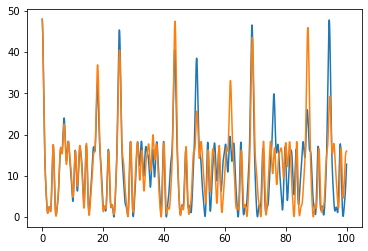

In [4]:
omega = np.array([1, np.sqrt(3)])

supp_F_K = np.array([[1,0], [0,1], [1,1]])

x = np.linspace(0,100,10000)

d = 3

tau = optimal_tau(omega, supp_F_K, d, x[1:])

tau2 = optimal_tau2(f, np.linspace(0,200,20000))

In [5]:
print(tau, tau2)

64.3964396439644 39.08195409770489


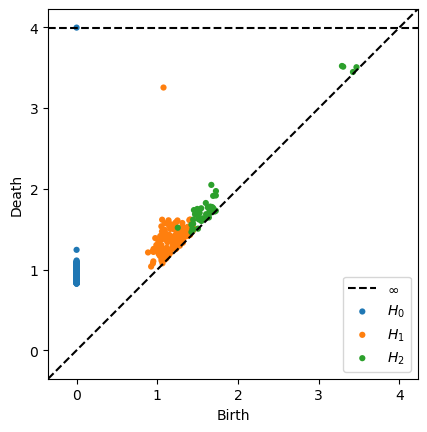

In [26]:
omega = np.array([1, np.sqrt(3)])

supp_F_K = np.array([[1,0], [0,1], [1,1]])

x = np.linspace(0,100,10000)

d = 3

#tau = optimal_tau(omega, supp_F_K, d, x[1:])

T = np.linspace(0, 200,5000)

SW_f = SW(f, T, d, np.random.uniform(0,100))

dgms = ripser(SW_f, maxdim=2, n_perm=200)['dgms']

plot_diagrams(dgms)

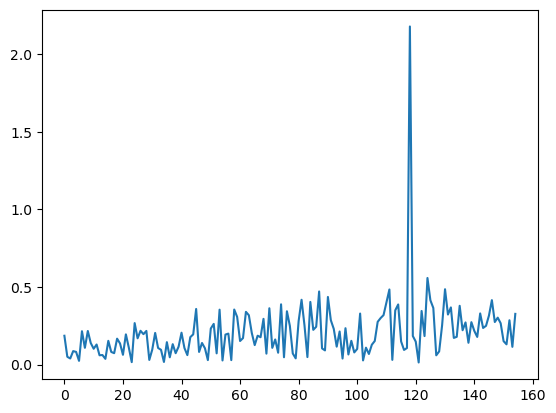

In [27]:
plt.plot(dgms[1][:,1] - dgms[1][:,0])